

# Traffic tracking with rotational ground motions
### Back azimuth estimation using vertical translational and two horizontal rotational ground motions
*Developed by Shihao Yuan (Colorado School of Mines); modified by Sabrina Keil*


<img src="coord.jpg" alt="drawing" width="300"/>
Figure 1. The right-hand coordinate system. Red arrow indicates the propagation direction of the plane wave with a polar angle ($\theta$) and azimuth ($\varphi$). Clockwise rotations from North or Z are positive while counterclockwise rotations are negative.



### For incident Rayleigh waves:

\begin{align} 
	\mathbf{s} =  \frac{1}{v}
	\begin{bmatrix}
	\sin \varphi \\
	\cos \varphi  \\
	0 \\
	\end{bmatrix},   \quad \quad     
	\mathbf{n} = 
	\begin{bmatrix}
	\sin \xi \sin \varphi \\
	\sin \xi \cos \varphi \\
	\cos \xi \\
	\end{bmatrix}, \quad \quad 
	\mathbf{s} \times \mathbf{n} =  \frac{1}{v} 
	\begin{bmatrix}
	 \cos \xi \cos \varphi  \\
	-\cos \xi \sin \varphi \\
	  0  \\[20pt]
	\end{bmatrix} , 
\end{align}

where the angle $\xi$ denotes ellipticity angle of the Rayleigh wave, determining the eccentricity and the sense of rotation of the particle motion. If $\xi \in (−\pi/2, 0)$, the Rayleigh wave elliptical motion is said to be retrograde. If $\xi \in (0, \pi/2)$ the wave is said to be prograde.


\begin{align}
	\text{Acceleration: } \mathbf{\ddot{u}} =   - \omega^2 A
	& 	\begin{bmatrix}
	\sin \xi \sin \varphi &\cos [ \omega (t - \mathbf{s} \cdot \mathbf{r}) + \phi ] \\
	\sin \xi \cos \varphi &\cos [ \omega (t - \mathbf{s} \cdot \mathbf{r}) + \phi ] \\
	\cos \xi  &\cos [ \omega (t - \mathbf{s} \cdot \mathbf{r}) + \phi + \pi/2] \\
	\end{bmatrix} , \\[10pt]
	\text{Rotational rate: } \mathbf{\dot{R}} =  A \frac{\omega^2}{v}
	& \begin{bmatrix}	
	 \cos \xi \cos \varphi  \\
	-\cos \xi \sin \varphi \\
	  0 \\ 
	\end{bmatrix} \cos [ \omega (t - \mathbf{s} \cdot \mathbf{r}) + \phi + \pi/2], 
\end{align}

where the vertical component acceleration has a $\pi/2$ phase shift compared to the horizontal components, causing elliptical particle motions. 

+ The same as SV waves, using two horizontal rotational components to estimate $\varphi$:

\begin{equation*}
    \varphi = - \arctan (\frac{\dot{R}_n}{\dot{R}_e})
\end{equation*}

The calculated $\varphi$ value from the inverse tangent ranges from $-90^\circ$ to $90^\circ$. We then convert it to the value between $0^\circ$ and $180^\circ$ by 

\begin{equation*}
\varphi = 
\begin{cases} \varphi, & \text{if } \varphi \geq 0 \\ \varphi + 180^\circ, & \mbox{if } \varphi < 0  \end{cases}.
\end{equation*}

Thus, the back azimuth $\varphi_{baz}$ (<font color='red'>with $180^\circ$ ambiguity</font>) is equal to

\begin{equation*}
\varphi_{baz} = \varphi \qquad   \text{or}  \qquad \varphi + 180
\end{equation*}

+ Removing $180^\circ$ ambiguity:

We rotate the east-west ($R_e$) and north-south ($R_n$) rotational components to radial ($R_r$) and transverse ($R_t$) components:

\begin{align*}
\begin{bmatrix} \dot{R}_r  \\ \dot{R}_t  \end{bmatrix} 
= \begin{bmatrix} -\sin \varphi_{baz} & -\cos \varphi_{baz}  \\ -\cos \varphi_{baz} & \sin \varphi_{baz}  \end{bmatrix} \begin{bmatrix} \dot{R}_e  \\ \dot{R}_n  \end{bmatrix}
=  A \frac{\omega^2}{v} \begin{bmatrix} 0  \\ \cos \xi  \end{bmatrix} \cos [ \omega (t - \mathbf{s} \cdot \mathbf{r}) + \phi + \pi/2].
\end{align*}

To remove the $180^{\circ}$, we can compare the transverse rotational component to vertical translational component. 

\begin{equation*}
\begin{bmatrix} \ddot{u}_z  \\ \dot{R}_t  \end{bmatrix}
= -  A \omega^2 \cos \xi \begin{bmatrix}  1  \\ -\frac{1}{v}  \end{bmatrix} \cos [ \omega (t - \mathbf{s} \cdot \mathbf{r}) + \phi + \pi/2].
\end{equation*}

If the trial $\varphi_{baz}$ with $180^\circ$ ambiguity is equal to the theorectical one, $\ddot{u}_z$ and $\dot{R}_t$ will be negtively correlated. If $\ddot{u}_z$ and $\dot{R}_t$ are positively correlated, we need to add $180^{\circ}$ to $\varphi_{baz}$.

In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
from obspy.geodetics import gps2dist_azimuth
from obspy import UTCDateTime
from obspy.signal.rotate import rotate2zne
from obspy.core.stream import Stream
from obspy.signal.cross_correlation import correlate
from obspy.signal.rotate import rotate_ne_rt
from obspy import read, read_inventory
import matplotlib.pyplot as plt
import matplotlib as mpl

# %matplotlib notebook

<figure>
  <IMG SRC="./sta_map.jpg" WIDTH=600 ALIGN="center">
</figure>
Figure 2. Map showing the study area and the location of chosen stations
    

<figure>
  <IMG SRC="./set-up.jpg" WIDTH=300 ALIGN="center">
</figure>
Figure 3. Station set-up using a Trillium Compact Seismometer and an iXblue blueSeis-3A rotational motion sensor

In [3]:
# Read inventory file
inventory_file_name = "inventory.xml"
inventory = read_inventory(inventory_file_name)

# Read 6C waveform
data_file_name  = "waveform.mseed"
waveform = read(data_file_name)

# Remove intrument response and convert particle velocity to acceleration 
waveform.select(channel='HH*').remove_response(inventory=inventory,output='ACC')
waveform.taper(max_percentage = 0.001)

# Band-pass filter 
f_low  = 3     # Hz
f_high = 18   # Hz
waveform_fil = waveform.copy()
waveform_fil.filter('bandpass',freqmin=f_low,freqmax=f_high,corners=4,zerophase=True)

#trim data
T1=UTCDateTime("2022-02-14T13:19:30.00")  
T2=UTCDateTime("2022-02-14T13:22:35.00")

waveform_fil.trim(T1,T2)

12 Trace(s) in Stream:
XX.BS3..HJE   | 2022-02-14T13:19:30.002200Z - 2022-02-14T13:22:35.002200Z | 100.0 Hz, 18501 samples
XX.BS3..HJN   | 2022-02-14T13:19:30.002200Z - 2022-02-14T13:22:35.002200Z | 100.0 Hz, 18501 samples
XX.BS3..HJZ   | 2022-02-14T13:19:30.002200Z - 2022-02-14T13:22:35.002200Z | 100.0 Hz, 18501 samples
XX.BS4..HJE   | 2022-02-14T13:19:30.004700Z - 2022-02-14T13:22:35.004700Z | 100.0 Hz, 18501 samples
XX.BS4..HJN   | 2022-02-14T13:19:30.004700Z - 2022-02-14T13:22:35.004700Z | 100.0 Hz, 18501 samples
XX.BS4..HJZ   | 2022-02-14T13:19:30.004700Z - 2022-02-14T13:22:35.004700Z | 100.0 Hz, 18501 samples
XX.TCBS3..HHE | 2022-02-14T13:19:30.000000Z - 2022-02-14T13:22:35.000000Z | 100.0 Hz, 18501 samples
XX.TCBS3..HHN | 2022-02-14T13:19:30.000000Z - 2022-02-14T13:22:35.000000Z | 100.0 Hz, 18501 samples
XX.TCBS3..HHZ | 2022-02-14T13:19:30.000000Z - 2022-02-14T13:22:35.000000Z | 100.0 Hz, 18501 samples
XX.TCBS4..HHE | 2022-02-14T13:19:30.000000Z - 2022-02-14T13:22:35.000000Z | 1

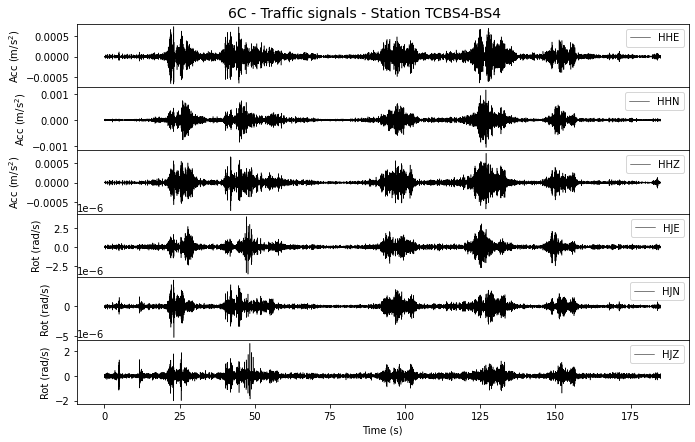

In [4]:
#Plot 6C data

################################ 
sta = '*BS4'   # '*BS3' (northern station);  *BS4 (southern station)
################################ 


chs = ['HHE','HHN','HHZ','HJE','HJN','HJZ']
# Plot the 6-DoF seismogram
fig, axs = plt.subplots(nrows=6,ncols=1,figsize=(10,6),sharex=True)
plt.subplots_adjust(hspace=0.0)
fig.suptitle("6C - Traffic signals - Station TC%s-%s" %(sta[1:],sta[1:]),fontsize=14,y=0.99)

for num_ch,ch in enumerate(chs):
    axs[num_ch].plot(waveform_fil.select(station=sta,channel=ch)[0].times() ,
                     waveform_fil.select(station=sta,channel=ch)[0].data,
                     color='k',linewidth=0.5,label=ch)
    if (num_ch < 3):
        axs[num_ch].set_ylabel(r"Acc (m/s$^{2}$)")
    else:
        axs[num_ch].set_ylabel(r"Rot (rad/s)")
    if (num_ch == 5): axs[num_ch].set_xlabel("Time (s)")
    axs[num_ch].legend(loc=1)

plt.subplots_adjust(left=0.1,bottom=0.07,right=0.95,top=0.95,hspace=0.0)
plt.show()


In [5]:
# Using polarization analysis of two horizontal rotational components to 
# retrieve the back azimuth of the traffic-induced Rayleigh waves

################################ 
# Station names
sta_acc = ['TCBS3','TCBS4']
sta_rot = ['BS3','BS4']

# Starting and ending time (in seconds)
t1 = 0 
t2 = 180 

# The length of the moving window and moving steps (in seconds)
win_len = 2.
win_step = 0.05 
################################ 

dt = waveform[0].stats.delta
t3 = np.int32(t1/dt)
t4 = np.int32(t2/dt)
wins = np.arange(0,t2-t1,win_step)
num_windows = len(wins) 

result_baz = np.empty((num_windows,3))
result_corr = np.empty((num_windows,2))

for num_sta,sta in enumerate(sta_acc):

    baz_cal = []
    t = []
    corrbaz = []
    
    for i_win in wins:

        t1_1 = t1 + i_win
        t2_1 = t1_1 + win_len
        t3_1 = np.int32(t1_1/dt)  
        t4_1 = np.int32(t2_1/dt)         
        
        data1  = (np.zeros((t4_1-t3_1,2)))    
        data1[:,0] = waveform_fil.select(station=sta_rot[num_sta],channel='HJE')[0].data[t3_1:t4_1]
        data1[:,1] = waveform_fil.select(station=sta_rot[num_sta],channel='HJN')[0].data[t3_1:t4_1]

        #relate north and east component of rotation rate to compute backzimuth
        C = np.cov(data1, rowvar=False)
        Cprime,Q = np.linalg.eigh(C,UPLO='U')
        loc = np.argsort(np.abs(Cprime))[::-1]
        Q = Q[:,loc]
        baz_tmp = -np.arctan((Q[1,0]/Q[0,0]))*180/np.pi 

        if baz_tmp <= 0:
            baz_tmp = baz_tmp + 180.

            
        #remove 180° ambiguity
        corrbazz = correlate(waveform_fil.select(station=sta_acc[num_sta],channel='HHZ')[0].data[t3_1:t4_1],
                             rotate_ne_rt(waveform_fil.select(station=sta_rot[num_sta],channel='HJN')[0].data[t3_1:t4_1], 
                                          waveform_fil.select(station=sta_rot[num_sta],channel='HJE')[0].data[t3_1:t4_1], baz_tmp)[1][:],0)
        
        if (corrbazz[0] > 0):
            baz_tmp = (180. + baz_tmp)

        baz_cal.append(baz_tmp)
        t.append(t1_1+win_len)
        corrbaz.append(np.abs(corrbazz[0]))
    
    baz_cal = np.array(baz_cal)
    t = np.array(t)
    corrbaz = np.array(corrbaz)
    
    result_baz[:,num_sta+1] = baz_cal
    result_corr[:,num_sta] = corrbaz
    
    print("Station: %s-%s" %(sta_acc[num_sta],sta_rot[num_sta]))
result_baz[:,0] = t

Station: TCBS3-BS3
Station: TCBS4-BS4


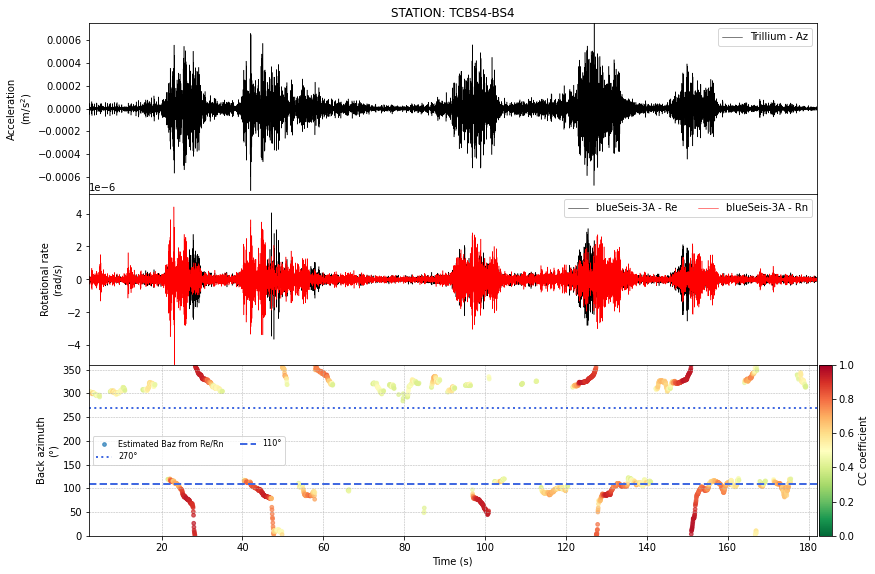

In [6]:
#Plot backazimuth estimates

#########################################
num_sta = 1 # 0: TCBS3-BS3 (northern station); 1: TCBS4-BS4 (southern station)
CC = 0.4  # set cross-correlation coefficient threshold for visualization
#########################################

plt.figure(figsize=(12,8))
#compute time axis
time0 = waveform_fil.select(station=sta_acc[num_sta],channel='HHZ')[0].times()
time1 = waveform_fil.select(station=sta_rot[num_sta],channel='HJE')[0].times() 
time2 = np.linspace(t1+win_len,t2+win_len,num_windows)
ylim1 = np.max([np.abs(waveform_fil.select(station=sta_acc[num_sta],channel='HHZ')[0].data)])
ylim2 = np.max([np.abs(waveform_fil.select(station=sta_rot[num_sta],channel='HJN')[0].data),\
                np.abs(waveform_fil.select(station=sta_rot[num_sta],channel='HJE')[0].data),
                np.abs(waveform_fil.select(station=sta_rot[num_sta],channel='HJZ')[0].data)])

# plot time series of Az
ax0 = plt.subplot2grid((3,50),(0,0), colspan=49)
ax0.plot(time0[:],waveform_fil.select(station=sta_acc[num_sta],channel='HHZ')[0].data,'k',
         linewidth=0.5,label="Trillium - Az")
ax0.set_title("STATION: %s-%s" %(sta_acc[num_sta],sta_rot[num_sta]))
ax0.set_xlim(t1+win_len,t2+win_len)
ax0.set_ylim(-ylim1, ylim1)
ax0.set_ylabel("Acceleration\n(m/s$^2$)")
ax0.legend(loc=1,ncol=2,prop={'size':10})
  

# plot time series of Re and Rn
ax1 = plt.subplot2grid((3,50),(1,0), colspan=49,sharex=ax0)
ax1.plot(time1,waveform_fil.select(station=sta_rot[num_sta],channel='HJE')[0].data,'k',
         linewidth=0.5,label="blueSeis-3A - Re")
ax1.plot(time1,waveform_fil.select(station=sta_rot[num_sta],channel='HJN')[0].data,'r',
         linewidth=0.5,label="blueSeis-3A - Rn")
ax1.set_xlim(t1+win_len,t2+win_len)
ax1.set_ylim(-ylim2,ylim2)
ax1.set_ylabel("Rotational rate\n(rad/s)")
ax1.legend(loc=1,ncol=2,prop={'size':10})   


# add colorbar
fig = plt.subplot2grid((3,50),(2,49))
norm = mpl.colors.Normalize(vmin=0.0,vmax=1)
cb1 = mpl.colorbar.ColorbarBase(fig,cmap=plt.cm.RdYlGn_r,
                                norm=norm,orientation='vertical',label="CC coefficient")

# plot backazimuth from Re/Rn
ax2 = plt.subplot2grid((3,50),(2,0),colspan=49,sharex=ax0)
index = np.where(result_corr[:,num_sta] > CC)  
ax2.scatter(t[index],result_baz[index,num_sta+1],c=result_corr[index,num_sta],cmap=plt.cm.RdYlGn_r,
            vmin=0.0,vmax=1,marker='.',s=55,alpha=0.7,label='Estimated Baz from Re/Rn')
ax2.set_xlim(t1+win_len,t2+win_len)
ax2.set_ylim(0,360)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Back azimuth\n(°)")
ax2.hlines(y=270,xmin=t1+win_len,xmax=t2+win_len,linestyle=':',
           linewidth=2,color='royalblue',label='270°')
ax2.hlines(y=110,xmin=t1+win_len,xmax=t2+win_len,linestyle='--',
           linewidth=2,color='royalblue',label='110°')
ax2.legend(loc=6,ncol=2,prop={'size':8})
ax2.grid(linestyle='--', linewidth=0.5)

plt.subplots_adjust(left=0.09,bottom=0.07,right=0.95,top=0.96,hspace=0.0)
plt.show()

### Back azimuth estimation for Love waves using transverse acceleration and vertical rotation rate

The estimation of the backazimuth (BAz = source direction angle) from the correlation of vertical rotation rate and transverse acceleration is illustrated as a simple example here:

We define the length of the time windows we want to use and calculate the number of time windows for
our downloaded waveform data.

For each time-window, we rotate the horizontal acceleration components through all possible
source directions (BAz, 0-360°) in 5°-steps. In each of the steps, we check the similarity (phase-match) between
vertical rotation rate and the transverses acceleration by cross-correlation (X-corr).

The rotation angle/ BAz-value yielding the highest correlation coefficient for the specific time window rotates the
horizontal acceleration components to radial/ transverse (= into the angular direction of the strongest signal source).


#### Vertical rotation rate and transverse acceleration are in phase!

In [7]:
#########################################
num_sta = 1 # 0: TCBS3-BS3 (northern station); 1: TCBS4-BS4 (southern station)
CC = 0.4  # set cross-correlation coefficient threshold for visualization
#########################################

# Starting and ending time (in seconds)
t1 = 0 
t2 = 180 # up to 600

# The length of the moving window and moving steps (in seconds)
win_len = 2.
win_step = 0.1 

dt = waveform[0].stats.delta
t3 = np.int32(t1/dt)
t4 = np.int32(t2/dt)
wins = np.arange(0,t2-t1,win_step)
num_windows = len(wins) 


# estimate the Backazimuth for each time window
step = 5
backas = np.linspace(0, 360 - step, int(360 / step))
corrbaz = []
t=[]
#ind=None
for i_deg in range(0, len(backas)):
    for i_win in wins:
        
        t1_1 = t1 + i_win
        t2_1 = t1_1 + win_len
        t3_1 = np.int32(t1_1/dt)  
        t4_1 = np.int32(t2_1/dt) 
        
        
        corrbazz = correlate(waveform_fil.select(station=sta_rot[num_sta],channel='HJZ')[0].data[t3_1:t4_1],
                             rotate_ne_rt(waveform_fil.select(station=sta_acc[num_sta],channel='HHN')[0].data,
                                          waveform_fil.select(station=sta_acc[num_sta],channel='HHE')[0].data, backas[i_deg])
                             [1][t3_1:t4_1],0)
        corrbaz.append(corrbazz[0])
        t.append(t1_1+win_len)
        
corrbaz = np.asarray(corrbaz)
corrbaz = corrbaz.reshape(len(backas), num_windows)
t = np.array(t)

maxcorr = []
corr_val=[]
for l1 in range(0, num_windows):
    maxcor_r = backas[corrbaz[:, l1].argmax()]
    maxcorr.append(maxcor_r)
    corr_val.append(max(corrbaz[:, l1]))
    
maxcorr = np.asarray(maxcorr)
corr_val=np.array(corr_val)

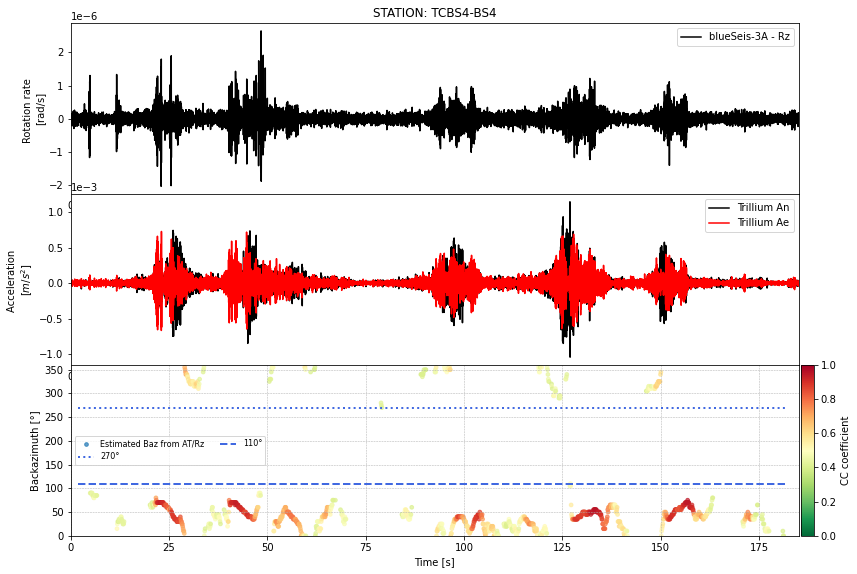

In [8]:
#Plot backazimuth estimates
plt.figure(figsize=(12,8))

sampling_rate = int(waveform[0].stats.sampling_rate)
time = np.linspace(0, len(waveform_fil.select(station=sta_acc[num_sta],channel='HHN')[0].data)/
                   sampling_rate,len(waveform_fil.select(station=sta_acc[num_sta],channel='HHN')[0].data)) ## Time-array

# vertical rotation rate
ax0=plt.subplot2grid((3, 50), (0, 0), colspan=49)
ax0.plot(time, waveform_fil.select(station=sta_rot[num_sta],channel='HJZ')[0].data,"k",label='blueSeis-3A - Rz')
ax0.set_xlim(0, time[-1])
ax0.set_ylabel('Rotation rate \n[rad/s]')
ax0.set_title("STATION: %s-%s" %(sta_acc[num_sta],sta_rot[num_sta]))
ax0.legend()


# north and east acceleration
ax1=plt.subplot2grid((3, 50), (1, 0), colspan=49,sharex=ax0)
ax1.plot(time, waveform_fil.select(station=sta_acc[num_sta],channel='HHN')[0].data, 'k',label='Trillium An')
ax1.plot(time, waveform_fil.select(station=sta_acc[num_sta],channel='HHE')[0].data, 'red',label='Trillium Ae')
ax1.set_ylabel('Acceleration \n[$m/s^2$]')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax1.legend()


# add colorbar
fig = plt.subplot2grid((3,50),(2,49))
norm = mpl.colors.Normalize(vmin=0.0,vmax=1)
cb1 = mpl.colorbar.ColorbarBase(fig,cmap=plt.cm.RdYlGn_r,
                                norm=norm,orientation='vertical',label="CC coefficient")

# backazimuth estimation plot
ax2=plt.subplot2grid((3, 50), (2, 0), colspan=49,sharex=ax0)
index = np.where(corr_val > CC) 
ax2.scatter(t[index],maxcorr[index],c=np.array(corr_val[index]),cmap=plt.cm.RdYlGn_r,
            vmin=0.0,vmax=1,marker='.',s=55,alpha=0.7,label='Estimated Baz from AT/Rz')
ax2.hlines(y=270,xmin=t1+win_len,xmax=t2+win_len,linestyle=':',
           linewidth=2,color='royalblue',label='270°')
ax2.hlines(y=110,xmin=t1+win_len,xmax=t2+win_len,linestyle='--',
           linewidth=2,color='royalblue',label='110°')
ax2.set_ylim(0, 360)
ax2.set_ylabel(u'Backazimuth [°]')
ax2.set_xlabel('Time [s]')
ax2.grid(linestyle='--', linewidth=0.5)
ax2.legend(loc=6,ncol=2,prop={'size':8})

plt.subplots_adjust(left=0.09,bottom=0.07,right=0.95,top=0.96,hspace=0.0)
plt.show()